In [112]:
import xgboost
import shap
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import plots as plots
import pickle
import lime
import lime.lime_tabular

# Load data and models

In [113]:
data = pickle.load(open('xgb_models/data5.pkl', 'rb'))
model = pickle.load(open('xgb_models/opt_XGB_YN0.pkl', 'rb'))

X_train_target = data['X_train_target']
X_train_target = X_train_target.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)
X_test_target = data['X_test_target']
X_test_target = X_test_target.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)
X = data['X']
X = X.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)

X_train = data['X_train']
X_train = X_train.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)
X_test = data['X_test']
X_test = X_test.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)
X_val = data['X_val']
X_val = X_val.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)
X_all = data['X_all']
X_all = X_all.drop(['PGA (g)', 'Elevation', '4m_Qtncs_m', '4m_Qtncs_s', '4m_Ic_med', '4m_Ic_std'], axis=1)

y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']
y = data['y']

In [114]:
X.head()

Test ID   GWD (m)    L (km)  Slope (%)  Target
0  15635.0  1.300896  0.211770   0.905948       0
1  15629.0  1.788212  0.115795   0.451034       0
2    183.0  1.637517  0.137265   0.941866       1
3    158.0  1.165643  0.073885   2.699290       0
4    180.0  2.121364  0.119745   1.187781       0

## Accuracy

In [115]:
print('Training score: %.2f%%' %(model.score(X_train, y_train) * 100))
print('Testing score: %.2f%%' %(model.score(X_test, y_test) * 100))
print('Overall score: %.2f%%' %(model.score(X_all, y) * 100))

Training score: 76.20%
Testing score: 76.92%
Overall score: 76.13%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


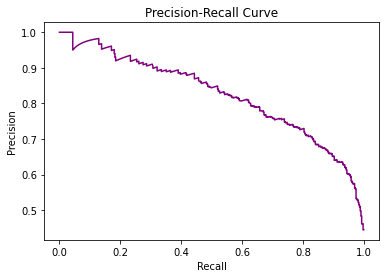

In [116]:
#use logistic regression model to make predictions
y_score = model.predict_proba(X_test)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [117]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


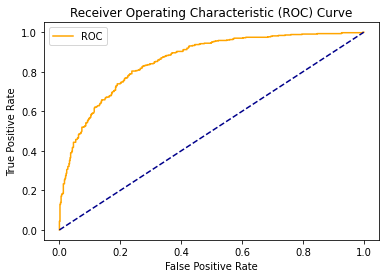

In [118]:
probs = model.predict_proba(X_test)[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs) 
plot_roc_cur(fper, tper)

In [119]:
def plot_summary(idx, shap_values, Xdata):
    shap.plots.waterfall(shap_values[idx])
    plots.prob_barh(model.predict_proba(Xdata)[idx])
    print('Percentile compare to the overall dataset')
    plots.percentile_score(shap_values[idx],Xdata)

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


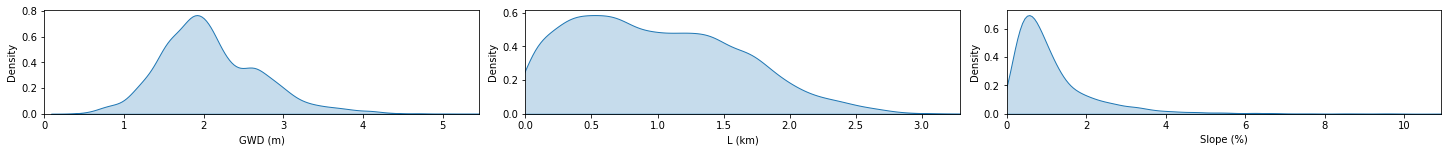

In [120]:
plots.distribution(X_all)

# Local explanations

## Training dataset

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


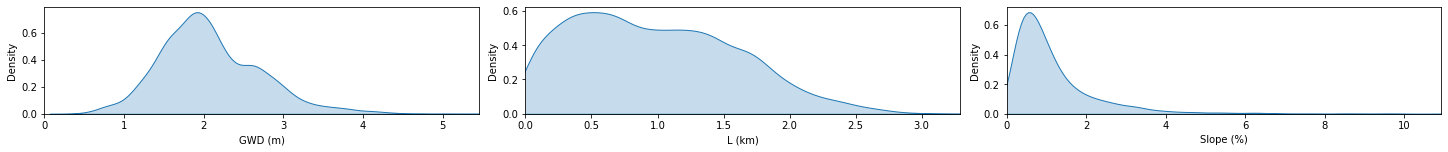

In [111]:
plots.distribution(X_train)

## Case of lateral spreading

In [121]:
# explain the model's predictions using SHAP
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [122]:
feature_names = ['GWD (m)', 'L (km)', 'Slope (%)']
target_names = ['Lateral Spreading', 'No Lateral Spreading']
lm = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=target_names, discretize_continuous=False)

In [123]:
X_train.reset_index()
X_train_target = X_train_target.reset_index()

In [124]:
X_train_target.loc[X_train_target['Target']==1].loc[X_train_target['L (km)'] < 0.1]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target
26     5829  24517.0  1.885435  0.067296   0.171548       1
32     3880  15772.0  1.436169  0.055705   0.518974       1
53     3979  25089.0  1.397046  0.072770   0.246042       1
55      189  15771.0  1.175442  0.053438   0.970473       1
74     5883  24531.0  1.926204  0.063073   0.493038       1
79     5774  24551.0  1.768948  0.054750   0.185273       1
90     3975  24534.0  1.478375  0.081088   0.246042       1
132    5744  23848.0  1.978947  0.066891   1.405303       1
143    5296    120.0  0.757456  0.007051   2.633182       1
145    5288    119.0  0.812953  0.011328   3.519404       1
159    4024  38304.0  1.593081  0.044541   2.150381       1
177    5703   1133.0  2.151764  0.011646   4.964096       1
189    6134  43884.0  3.417380  0.097346   4.352374       1
206    5699   1139.0  1.416061  0.008363   2.434030       1
334    3969  29004.0  1.561431  0.087830   0.246042       1
379    5841  24526.0  1.885435  0.079113   0.190712       1
399    3971  25092.0  1.561431  0.085229   0.246042       1
402    5719    853.0  1.624479  0.019670   0.677515       1
452    5342   1124.0  1.565938  0.011934   1.990739       1
476    5798  24557.0  1.882595  0.086243   0.297980       1
478     192  44347.0  1.075043  0.097810   0.233087       1
502    5717   1135.0  1.598034  0.008469   3.301802       1
527    5316    118.0  0.779310  0.013118   1.493483       1
554    5792  21565.0  1.768948  0.065057   0.198495       1
595    5860  32015.0  1.874951  0.068569   0.558119       1
618    5730  21570.0  1.978947  0.060293   1.405303       1
627    5790  23827.0  1.768948  0.064338   0.198495       1
653    5976  28683.0  2.133120  0.092059   0.673289       1
677    5507   1130.0  1.702312  0.002360   2.845001       1
692    5784  23828.0  1.768948  0.062103   0.198495       1
700    5890  27982.0  1.974449  0.095689   0.276910       1
759    5334    122.0  1.187627  0.003349   1.312968       1
763    5743  23823.0  2.013019  0.059336   0.808634       1
781    5690    851.0  1.185998  0.008484   0.898328       1
792    5742  28631.0  1.978947  0.065587   1.405303       1
813    1387  18813.0  1.638528  0.086969   0.539070       1
830    5244    514.0  1.578795  0.038956   1.247327       1
864    5937  37463.0  2.097750  0.081564   0.317614       1
892    3981  25087.0  1.397046  0.066261   0.239332       1
900    6383     60.0  1.577822  0.025260   1.610507       1
914    5343  29020.0  1.558376  0.013864   1.660699       1
918    5687  15094.0  2.392963  0.086303   3.873547       1
929    5739  23853.0  1.978947  0.063843   1.405303       1
931    5866     43.0  1.820144  0.034578   1.039747       1
976    5808     39.0  1.744039  0.043764   0.440833       1
1041   5897  32023.0  1.974449  0.091822   0.569717       1
1044   5898  24746.0  1.926204  0.062116   0.715357       1
1103   5769  15794.0  1.768948  0.050571   0.185273       1
1110   5763    857.0  1.749512  0.016479   1.192736       1
1112   5886  32021.0  1.974449  0.093031   0.614052       1
1150   5885  27921.0  1.926204  0.065604   0.493038       1
1159   3553  15634.0  0.992563  0.081746   0.267785       1
1174   3978  23845.0  1.478375  0.079152   0.246042       1
1205   5251    112.0  0.949546  0.013271   3.111239       1
1213   6118     55.0  2.028212  0.016688   4.263811       1
1218   5823  24524.0  1.869850  0.072986   0.674246       1
1253   5735  21567.0  2.013019  0.058407   0.749356       1
1323   1524  16849.0  2.505355  0.075615   0.421888       1
1343   5830  21572.0  1.869850  0.078492   0.519532       1
1348   5287    520.0  0.705082  0.008790   3.552589       1
1351   5875  27929.0  1.874951  0.080562   0.614052       1
1379   5714   1134.0  1.358710  0.012328   2.638542       1
1400   5758  28765.0  1.851072  0.055744   0.570542       1
1417   6359     59.0  1.601711  0.022426   1.616601       1
1461   5733  27333.0  2.013019  0.055680   0.808634       1
1464   5698  15681.0  1.289473  0.079225   0.3

This is the case where the length to the river is short

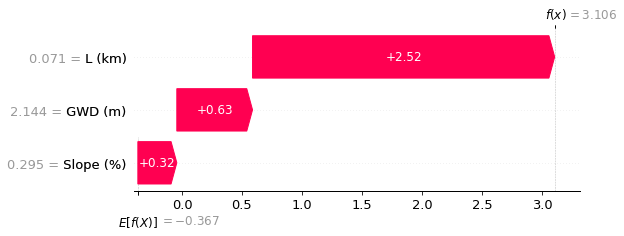

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


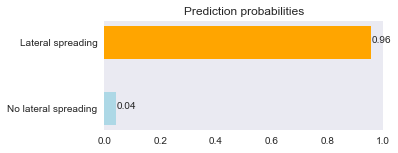

Percentile compare to the overall dataset


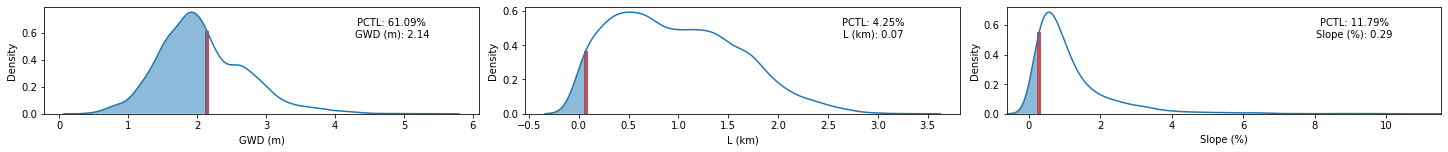

In [127]:
idx = 5141
plot_summary(idx, shap_values, X_train)

In [128]:
idx = 5141
exp = lm.explain_instance(X_train.iloc[idx], model.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(predict_proba=False)

## Case of no lateral spreading

In [129]:
X_train_target.loc[X_train_target['Target']==0].loc[X_train_target['L (km)'] > 3]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target
60     4097  32250.0  1.023264  3.069003   0.109984       0
1314   4085  19563.0  1.667777  3.289537   0.068539       0
2086   4103  16832.0  0.669578  3.001999   1.740389       0
2768   4100  22454.0  1.058862  3.084513   0.768944       0

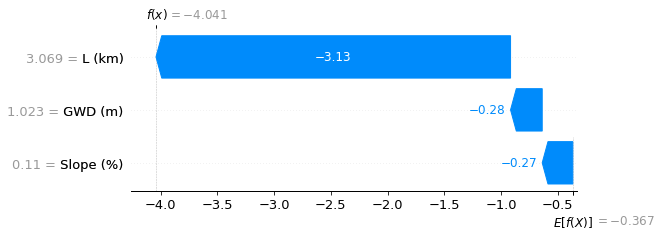

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


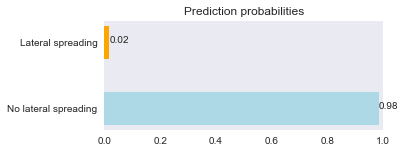

Percentile compare to the overall dataset


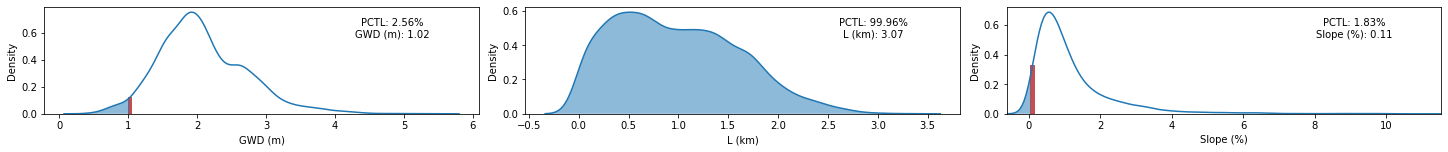

In [130]:
# visualize no lateral spreading prediction explanation
idx = 60
plot_summary(idx, shap_values, X_train)

In [131]:
idx = 60
exp = lm.explain_instance(X_train.iloc[idx], model.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(predict_proba=False)

# Local explanations (Grouped by Type)

## Accuracy

In [132]:
# make prediction
preds = model.predict(X_test)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.92%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [133]:
# Create a dataframe with errors
test_targets = X_test_target['Target']
error = predictions - test_targets
testdf = pd.concat([X_test_target, pd.DataFrame({'error':error})], axis=1)

## True Positive

In [134]:
# Target = 1 (lateral spreading)
tp = testdf[testdf['error'] == 0]
tp = tp[tp['Target'] == 1]

X_true_pos = tp.drop(['Test ID', 'Target', 'error'], axis=1)
tp.head()

Test ID   GWD (m)    L (km)  Slope (%)  Target  error
5796  28764.0  1.882595  0.083856   0.297980       1      0
5834  21574.0  1.885435  0.075817   0.171548       1      0
5775  23840.0  1.807612  0.055638   0.185273       1      0
3057  54886.0  1.788936  0.987352   0.418441       1      0
5828  23812.0  1.869850  0.076099   0.519532       1      0

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


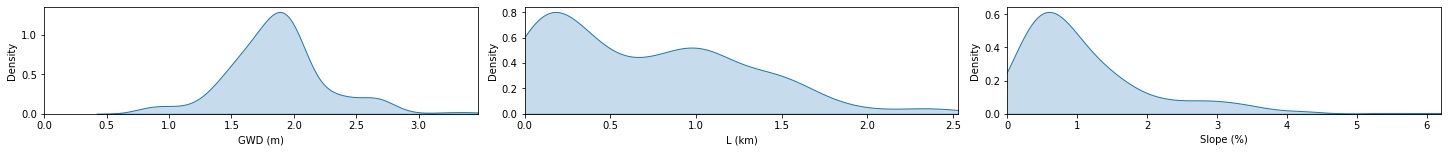

In [135]:
plots.distribution(X_true_pos)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


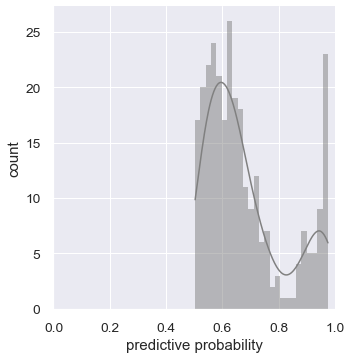

In [136]:
# Prediction probability
prob = model.predict_proba(X_true_pos)
plots.pred_prob(prob[:,1])

In [137]:
# SHAP values of false positive dataset
tp_shap_values = explainer(X_true_pos)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [196]:
tp.head()

Test ID   GWD (m)    L (km)  Slope (%)  Target  error
5796  28764.0  1.882595  0.083856   0.297980       1      0
5834  21574.0  1.885435  0.075817   0.171548       1      0
5775  23840.0  1.807612  0.055638   0.185273       1      0
3057  54886.0  1.788936  0.987352   0.418441       1      0
5828  23812.0  1.869850  0.076099   0.519532       1      0

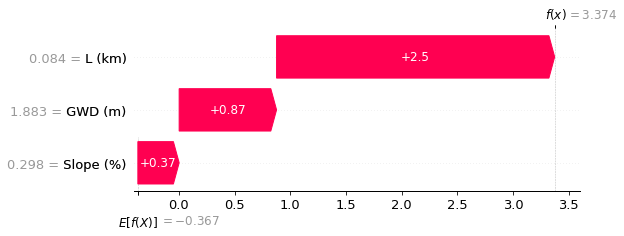

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


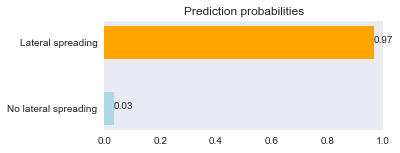

Percentile compare to the overall dataset


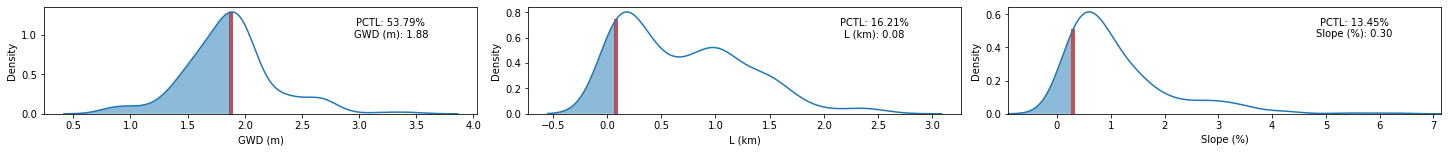

In [198]:
plot_summary(0, tp_shap_values, X_true_pos)

#### Large distance (L > 2 km), why do we still predict lateral spreading?

In [139]:
tpfar = tp[tp['L (km)'] > 2]
Xfar = tpfar.drop(['Test ID', 'Target', 'error'], axis=1)
tpfar.head()

Test ID   GWD (m)    L (km)  Slope (%)  Target  error
4110  38514.0  0.805172  2.531656   0.502326       1      0
4116  34718.0  1.027273  2.233438   0.506840       1      0
4131  16689.0  0.851762  2.367820   0.679290       1      0
4104  48825.0  0.939028  2.374267   0.837824       1      0
4109  48826.0  0.980644  2.370803   0.769912       1      0

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


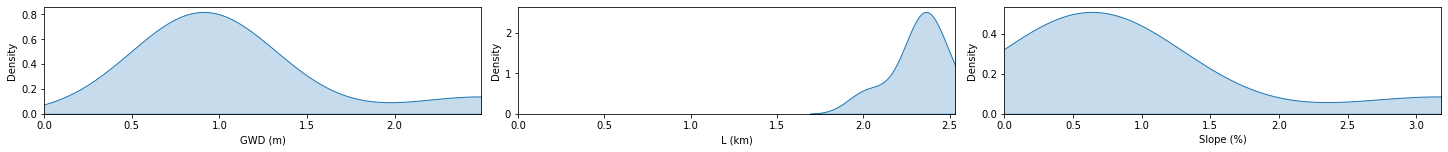

In [140]:
plots.distribution(Xfar)

In [141]:
# SHAP values of X far dataset
xfar_shap_values = explainer(Xfar)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Length is > 2.45 kms but the GWD is closer to the surface

In [142]:
tpfar = tpfar.reset_index()
tpfar.loc[tpfar['L (km)']>2]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0   4110  38514.0  0.805172  2.531656   0.502326       1      0
1   4116  34718.0  1.027273  2.233438   0.506840       1      0
2   4131  16689.0  0.851762  2.367820   0.679290       1      0
3   4104  48825.0  0.939028  2.374267   0.837824       1      0
4   4109  48826.0  0.980644  2.370803   0.769912       1      0
5   4148  22354.0  0.850854  2.354993   0.534235       1      0
6   1605  37331.0  2.493565  2.015940   3.180131       1      0

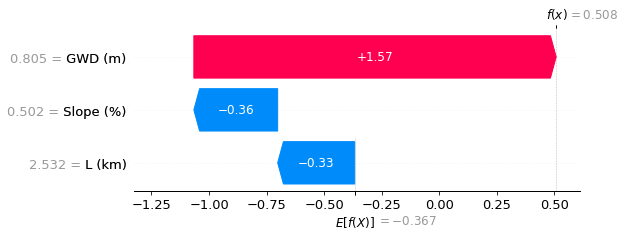

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


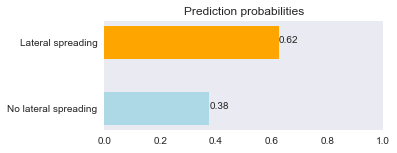

Percentile compare to the overall dataset


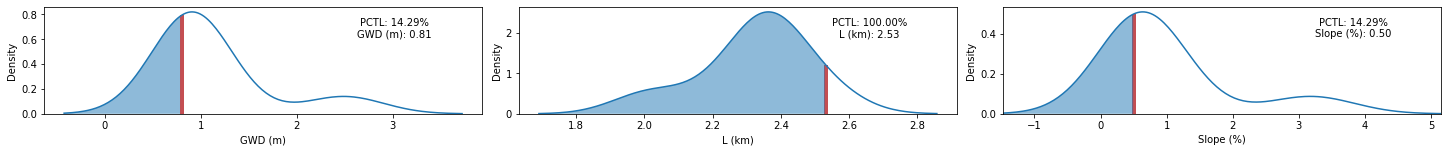

In [147]:
# visualize lateral spreading prediction's explanation
idx = 0
plot_summary(idx, xfar_shap_values, Xfar)

## True Negative

In [148]:
# Target = 0 (no-lateral spreading)
tn = testdf[testdf['error'] == 0]
tn = tn[tn['Target'] == 0]

X_true_neg = tn.drop(['Test ID', 'Target', 'error'], axis=1)
tn = tn.reset_index()
tn.head()

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0   2850   2556.0  2.249877  0.984994   2.167620       0      0
1   1643  32907.0  2.778554  1.450625   0.993102       0      0
2    119    513.0  1.605895  2.199005   0.237995       0      0
3   4321  34314.0  2.248602  2.622328   0.274640       0      0
4   6297  37672.0  2.057632  0.284873   0.111626       0      0

In [149]:
tn[tn['GWD (m)'] < 1.0]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
15    4108  32511.0  0.808329  2.529715   0.395249       0      0
19    4090  37128.0  0.509307  2.809299   1.173059       0      0
97    1634  38406.0  0.703270  1.834121   9.416513       0      0
120   4186   1979.0  0.672116  1.686450   0.869256       0      0
208   4333  14224.0  0.932215  0.959053   0.385024       0      0
242   4570   5145.0  0.824801  1.104377   1.726856       0      0
305   4132  43920.0  0.721545  2.647230   0.420387       0      0
327   6695  24220.0  0.420519  1.822826   0.400673       0      0
338   4095  37129.0  0.927009  2.780764   0.883209       0      0
372   4126  42198.0  0.753128  2.665493   0.506256       0      0
445   4155  29836.0  0.672757  2.529131   1.186927       0      0

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


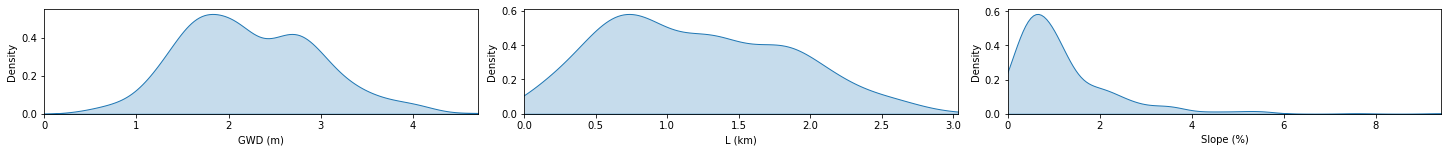

In [150]:
plots.distribution(X_true_neg)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


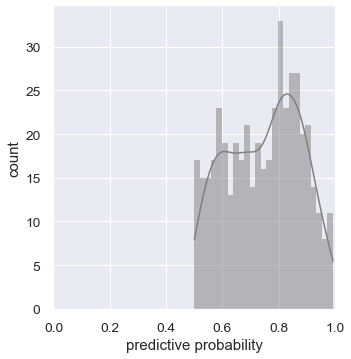

In [151]:
# Prediction probability
prob = model.predict_proba(X_true_neg)
plots.pred_prob(prob[:,0])

In [152]:
# SHAP values of X far dataset
tn_shap_values = explainer(X_true_neg)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### No lateral spreading due to far away distance

In [153]:
tn.loc[tn['L (km)'] > 2].head()

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
2     119    513.0  1.605895  2.199005   0.237995       0      0
3    4321  34314.0  2.248602  2.622328   0.274640       0      0
9    4428  37710.0  1.829858  2.068942   0.791967       0      0
12   4105  32251.0  1.017751  3.034131   0.480071       0      0
15   4108  32511.0  0.808329  2.529715   0.395249       0      0

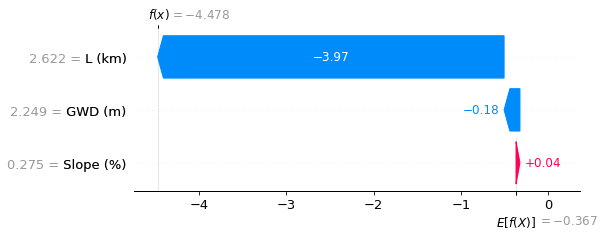

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


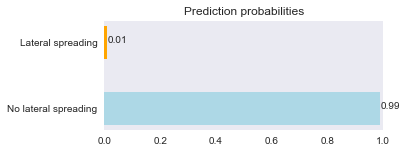

Percentile compare to the overall dataset


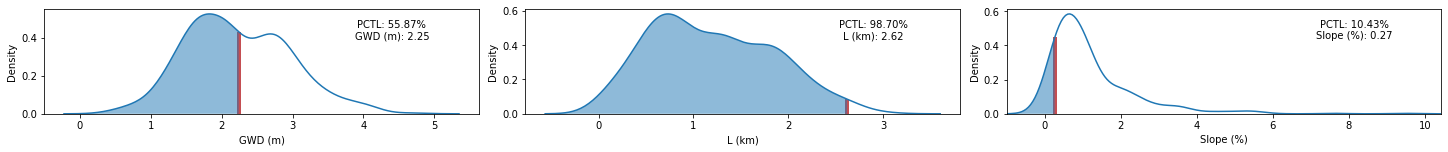

In [156]:
plot_summary(3, tn_shap_values, X_true_neg)

### True negative at short distances (L)

In [157]:
tn.loc[tn['L (km)'] < 0.5].loc[tn['GWD (m)'] > 3]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
20    1805  25621.0  3.443651  0.169952   1.890133       0      0
30    5097   4014.0  3.406002  0.241764   1.034272       0      0
33    1558  12460.0  3.095618  0.421687   1.024821       0      0
43    1829  25634.0  3.019168  0.193225   3.061359       0      0
201    919  17611.0  3.370925  0.386230   0.619478       0      0
220   1386  37741.0  3.456206  0.169971   3.791025       0      0
234    257  15617.0  3.809646  0.181716   1.720116       0      0
335   5107  46042.0  3.019693  0.335411   0.392997       0      0
362   5074   5970.0  3.044290  0.287614   0.383352       0      0

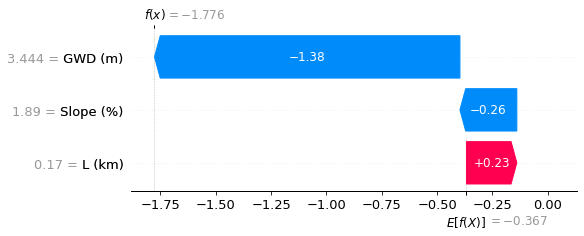

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


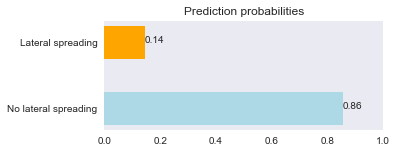

Percentile compare to the overall dataset


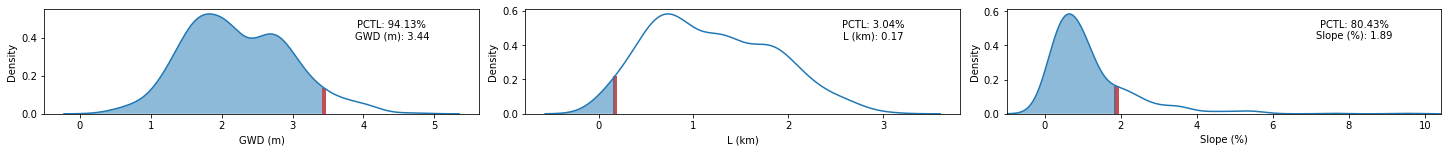

In [158]:
# visualize no lateral spreading prediction's explanation (3)
idx = 20
plot_summary(idx, tn_shap_values, X_true_neg)

# False positive

In [159]:
# Error is 1 means prediction 1 (lateral spreading) while target is 0 (no-lateral spreading)
fp = testdf[testdf['error'] == 1]
X_false_pos = fp.drop(['Test ID', 'Target', 'error'], axis=1)
fp = fp.reset_index()
fp

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0     161  38414.0  2.018221  0.681779   0.632241       0      1
1     895  11469.0  2.475069  1.567143   1.182557       0      1
2    2235  25896.0  2.186488  1.370897   0.508970       0      1
3    6300  15303.0  2.010932  0.205895   1.333204       0      1
4    3094  37532.0  2.487671  1.492929   1.000127       0      1
5    3879  33830.0  2.408835  1.687515   0.531799       0      1
6    5470  10021.0  1.982319  0.396546   0.120454       0      1
7    6319  28553.0  1.912209  0.304971   0.649830       0      1
8    1036   9106.0  2.292009  1.539813   0.628904       0      1
9    4505  11219.0  2.097190  1.599028   0.816955       0      1
10   5390  25522.0  1.850918  0.268163   1.628136       0      1
11   2256  54577.0  2.265366  1.325771   0.520274       0      1
12     14  38483.0  2.390335  1.507054   1.384756       0      1
13   3209   4331.0  1.525343  0.543171   0.617342       0      1
14   5151   3764.0  2.580149  0.257180   4.580277       0      1
15    920  20805.0  2.168513  0.283681   3.124813       0      1
16   6318   6287.0  1.782492  0.376998   1.131772       0      1
17    527  37801.0  2.191347  1.477126   0.433542       0      1
18   6322   5229.0  1.843618  0.199148   0.292936       0      1
19   4725  37688.0  1.913390  0.966107   0.927475       0      1
20   5516  39562.0  1.628143  0.729847   1.403344       0      1
21    143  16481.0  2.007141  0.789934   0.961416       0      1
22    530  39025.0  1.801311  1.227596   2.925875       0      1
23    830  14934.0  1.827522  0.398574   1.494957       0      1
24    526  10723.0  2.191347  1.476400   0.433542       0      1
25   4976  42301.0  2.160123  1.276502   0.453046       0      1
26   1360  19793.0  2.119855  0.963294   0.726245       0      1
27   6089  13716.0  2.013828  0.384760   0.821370       0      1
28    609  19795.0  1.937774  1.166352   0.526232       0      1
29   6280   4674.0  1.942719  0.253668   0.637472       0      1
30   6621  12174.0  1.599113  1.167620   0.239152       0      1
31   6384     80.0  1.766789  0.231621   1.079558       0      1
32    882   9091.0  2.312410  1.054068   0.746312       0      1
33   3195  54920.0  2.498909  1.478695   0.713143       0      1
34     98  50433.0  1.678321  1.026364   1.142205       0      1
35   4453  37702.0  2.159158  1.678537   0.505989       0      1
36   6699  43157.0  1.536784  0.390255   0.912147       0      1
37    877     46.0  1.723269  0.154349   0.642502       0      1
38    465  25725.0  2.662099  1.422397   2.430579       0      1
39    495  23631.0  2.295763  1.387961   0.923123       0      1
40    172  15663.0  1.723042  0.543028   2.093917       0      1
41   6321  28552.0  1.912209  0.331335   1.317586       0      1
42   5449  48801.0  2.320397  0.522329   2.578518       0      1
43   6151  13798.0  1.835076  0.744325   0.349786       0      1
44   6000  38473.0  2.039879  0.448070   0.499212       0      1
45   2877  26039.0  1.858528  0.985548   0.268774       0      1
46    912  17484.0  3.317045  0.452786   0.847155       0      1
47   6394  31986.0  1.952103  0.279199   0.719322       0      1
48   4057   9294.0  1.528249  0.161050   2.423025       0      1
49   6015   5058.0  1.717497  0.487819   1.192646       0      1
50   5024  45099.0  2.160447  1.140048   0.584055       0      1
51   1399  26297.0  2.296730  1.567897   1.503300       0      1
52   6093  21350.0  1.535656  0.592491   1.243416       0      1
53   5946  54072.0  2.013404  0.345629   0.303981       0      1
54   6296  54298.0  2.010932  0.221196   0.293862       0      1
55   3320  10845.0  2.288344  1.568534   0.250199       0      1
56   6469   6382.0  2.012480  0.337728   0.843485       0      1
57   2274  32605.0  2.346719  1.571875   0.690963       0      1
58   6299  21085.0  1.642619  0.475091   1.745942       0      1
59    467  25727.0  2.401429  1.217839   3.363454       0      1
60   5992  14096.0  2.640565  0.035327 

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


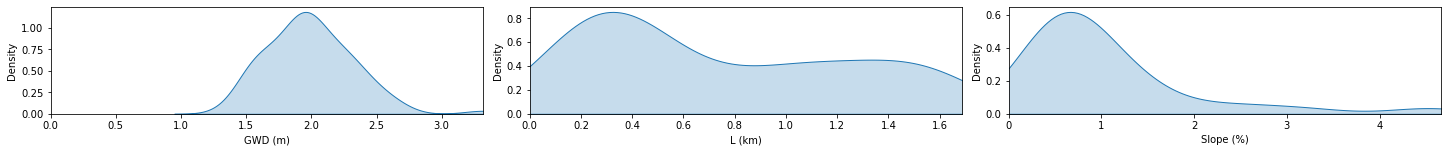

In [160]:
plots.distribution(X_false_pos)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


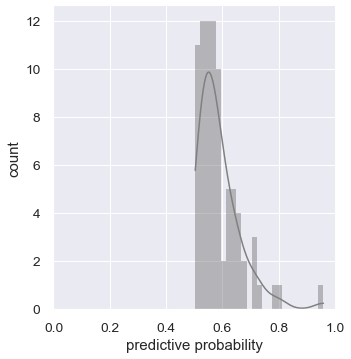

In [161]:
# Prediction probability
prob = model.predict_proba(X_false_pos)
plots.pred_prob(prob[:,1])

In [162]:
# SHAP values of false positive dataset
fp_shap_values = explainer(X_false_pos)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Fails for close distance to river

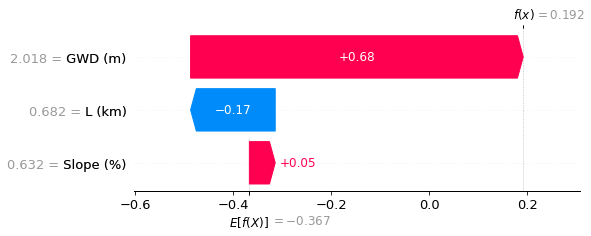

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


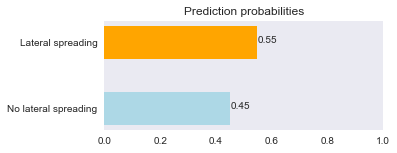

Percentile compare to the overall dataset


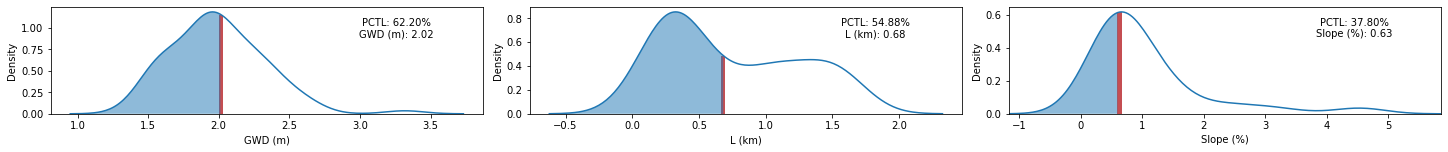

In [163]:
# visualize lateral spreading prediction's explanation - The elevation and slope values are zero
idx=0
plot_summary(idx, fp_shap_values, X_false_pos)

## High slope angle triggered a false positive

In [164]:
fp.loc[fp['Slope (%)'] > 4]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
14   5151   3764.0  2.580149  0.257180   4.580277       0      1
60   5992  14096.0  2.640565  0.035327   4.665368       0      1
75    170    341.0  2.056095  0.334436   4.331904       0      1

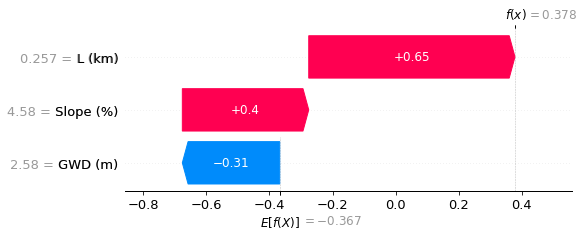

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


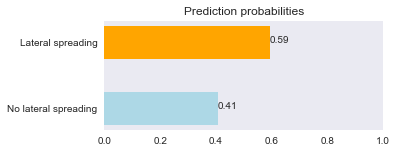

Percentile compare to the overall dataset


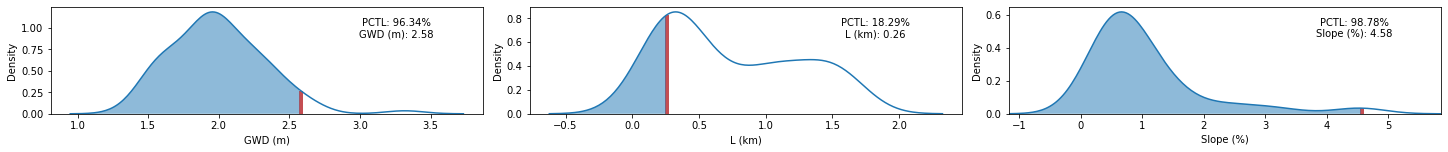

In [169]:
plot_summary(14, fp_shap_values, X_false_pos)

# False negatives

In [170]:
# Error is -1 means prediction 0 (no-lateral spreading) while target is 1 (lateral spreading)
fn = testdf[testdf['error'] == -1]

X_false_neg = fn.drop(['Test ID', 'Target', 'error'], axis=1)
fn = fn.reset_index()
fn

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0     3630  26109.0  1.790882  1.348634   0.262668       1     -1
1     2704  27657.0  2.522350  1.284956   1.072127       1     -1
2     2407   2167.0  1.237628  0.545491   0.790183       1     -1
3     5240  25510.0  2.610822  0.278138   0.674295       1     -1
4     3700   2511.0  1.623923  1.405393   0.620053       1     -1
5     3404  34285.0  1.889826  0.584355   1.070179       1     -1
6     5640  15700.0  0.776125  0.463957   0.338019       1     -1
7     2380  27611.0  1.587372  1.843400   0.541324       1     -1
8     4861  41788.0  1.938110  1.455014   1.330610       1     -1
9      706   9056.0  2.109729  0.333431   0.579430       1     -1
10    3336   4081.0  2.056047  0.581016   0.637624       1     -1
11    4882   8827.0  2.005785  0.675017   0.076536       1     -1
12    2253   6369.0  2.255180  0.487078   0.743259       1     -1
13     874   2689.0  3.004131  1.289772   1.657840       1     -1
14    4832  10818.0  2.739178  0.440049   0.745904       1     -1
15    1967  44375.0  2.593636  1.061021   1.106692       1     -1
16    3020   3997.0  2.743023  1.481691   0.172749       1     -1
17    2004  37676.0  3.228874  0.903165   1.914267       1     -1
18    2544  36978.0  2.146387  0.791734   0.574236       1     -1
19    3247   2332.0  1.405582  1.129939   0.798872       1     -1
20    4774   5269.0  1.721808  2.101612   0.719466       1     -1
21    3703  10861.0  2.733546  1.129143   2.574658       1     -1
22    6609  48656.0  2.302286  2.739961   0.545546       1     -1
23    6428  43694.0  2.204325  0.229406   0.955651       1     -1
24    6360  28952.0  2.083289  0.290537   0.426429       1     -1
25    6031   5060.0  2.109565  0.477694   0.505582       1     -1
26    1955  27346.0  2.740191  0.738508   1.259197       1     -1
27      66  43892.0  1.507806  1.345018   1.158615       1     -1
28     733  22278.0  2.174715  0.374807   1.209491       1     -1
29    3712  26118.0  1.917614  1.487111   1.265549       1     -1
30    5269  25157.0  3.039519  0.412140   0.721181       1     -1
31    2522  54207.0  1.865590  0.738620   1.057873       1     -1
32    2307  41404.0  2.519046  1.143560   0.875319       1     -1
33    4829  48974.0  2.116044  1.739393   0.728448       1     -1
34    3713  37199.0  2.412912  1.590388   4.995893       1     -1
35    4364  41257.0  1.382538  1.987355   0.899960       1     -1
36     188  48147.0  1.082345  0.436470   1.148642       1     -1
37    6080  27688.0  1.921987  0.652253   0.461309       1     -1
38    4906  19032.0  2.791991  0.460590   0.443877       1     -1
39    1887   9681.0  2.245238  0.303313   1.317297       1     -1
40    3615  39012.0  1.783073  1.667205   0.835999       1     -1
41    3264  31343.0  2.370643  1.312227   0.614238       1     -1
42    2777   3929.0  2.180351  0.847561   1.038253       1     -1
43    4675  23403.0  1.912391  0.635088   0.456155       1     -1
44    2833  23932.0  2.163261  0.290383   0.672333       1     -1
45    1157     22.0  1.739299  1.650195   0.920349       1     -1
46    5270  15374.0  3.039519  0.424118   0.721181       1     -1
47    2875   2466.0  2.102416  0.903481   0.396884       1     -1
48    5442   1090.0  2.398019  0.153221   1.968075       1     -1
49    1965  32937.0  2.058806  0.462337   0.594271       1     -1
50    3824  37956.0  1.682627  1.675251   0.929583       1     -1
51    3391  21682.0  1.782627  0.638543   0.859273       1     -1
52    1874  30452.0  2.708148  0.355644   1.336344       1     -1
53    3618  32841.0  1.524169  0.679989   2.486840       1     -1
54    3367  26094.0  2.351066  0.538181   0.938916       1     -1
55    4777   3781.0  1.710468  2.096897   1.343429       1     -1
56      30  17688.0  1.368858  1.473344   1.211723       1     -1
57    4367  22447.0  1.605430  1.972381   0.846380       1     -1
58    6418   9055.0  2.268378  0.188087   0.874391       1     -1
59     539  11061.0  3.315680  1.377305   3.6

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


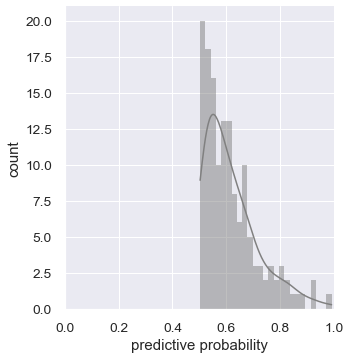

In [171]:
# Prediction probability
prob = model.predict_proba(X_false_neg)
plots.pred_prob(prob[:,0])

In [172]:
# SHAP values of false negative dataset
fn_shap_values = explainer(X_false_neg)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Distance is too far

In [173]:
fn.loc[fn['L (km)'] > 2]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
20    4774   5269.0  1.721808  2.101612   0.719466       1     -1
22    6609  48656.0  2.302286  2.739961   0.545546       1     -1
55    4777   3781.0  1.710468  2.096897   1.343429       1     -1
128   1690  24628.0  2.314934  2.317660   2.562188       1     -1

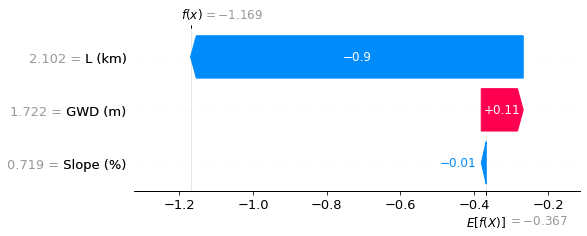

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


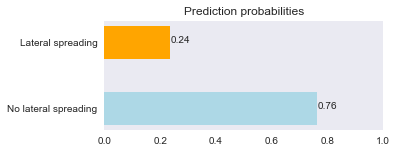

Percentile compare to the overall dataset


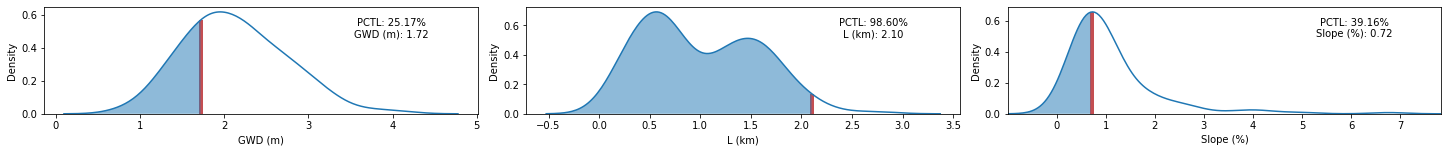

In [174]:
# The elevation and slope values are zero
idx=20
plot_summary(idx, fn_shap_values, X_false_neg)

### Distance is close but predicts false negative value

In [175]:
fn.loc[fn['L (km)'] < 0.5]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
3     5240  25510.0  2.610822  0.278138   0.674295       1     -1
6     5640  15700.0  0.776125  0.463957   0.338019       1     -1
9      706   9056.0  2.109729  0.333431   0.579430       1     -1
12    2253   6369.0  2.255180  0.487078   0.743259       1     -1
14    4832  10818.0  2.739178  0.440049   0.745904       1     -1
23    6428  43694.0  2.204325  0.229406   0.955651       1     -1
24    6360  28952.0  2.083289  0.290537   0.426429       1     -1
25    6031   5060.0  2.109565  0.477694   0.505582       1     -1
28     733  22278.0  2.174715  0.374807   1.209491       1     -1
30    5269  25157.0  3.039519  0.412140   0.721181       1     -1
36     188  48147.0  1.082345  0.436470   1.148642       1     -1
38    4906  19032.0  2.791991  0.460590   0.443877       1     -1
39    1887   9681.0  2.245238  0.303313   1.317297       1     -1
44    2833  23932.0  2.163261  0.290383   0.672333       1     -1
46    5270  15374.0  3.039519  0.424118   0.721181       1     -1
48    5442   1090.0  2.398019  0.153221   1.968075       1     -1
49    1965  32937.0  2.058806  0.462337   0.594271       1     -1
52    1874  30452.0  2.708148  0.355644   1.336344       1     -1
58    6418   9055.0  2.268378  0.188087   0.874391       1     -1
62    1992  32959.0  1.930622  0.465034   0.900893       1     -1
66    3730  19186.0  1.768563  0.228149   0.157506       1     -1
73    6382  14217.0  1.948803  0.127597   0.900676       1     -1
78    3839  10920.0  2.409976  0.414932   1.793514       1     -1
82    2393   2168.0  1.108662  0.476856   0.670128       1     -1
84    5023  11216.0  2.989932  0.292802   0.964330       1     -1
90     195  25867.0  1.173311  0.223865   0.544942       1     -1
92    2163  37098.0  2.300045  0.306370   2.176433       1     -1
100   2172  25877.0  2.576054  0.341519   1.028578       1     -1
109   5363  25180.0  2.987893  0.109311   0.806815       1     -1
119   5319     99.0  2.193741  0.205243   1.081549       1     -1
123   2363   9014.0  1.353115  0.479754   0.445521       1     -1
126    747     82.0  2.039629  0.496335   1.177489       1     -1
130   2348   9016.0  1.353115  0.461062   0.327673       1     -1
135   5212  23157.0  2.844810  0.219859   1.789048       1     -1
139   5060  46062.0  3.119499  0.236329   0.110669       1     -1

### Deeper GWD

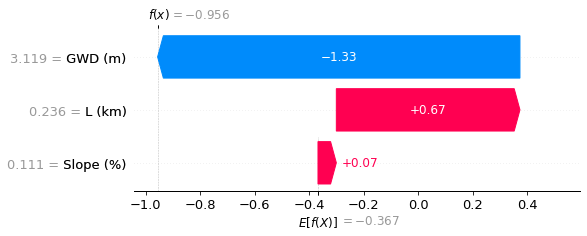

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


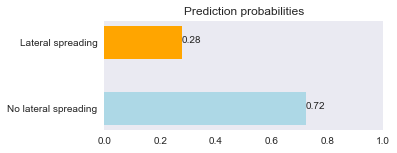

Percentile compare to the overall dataset


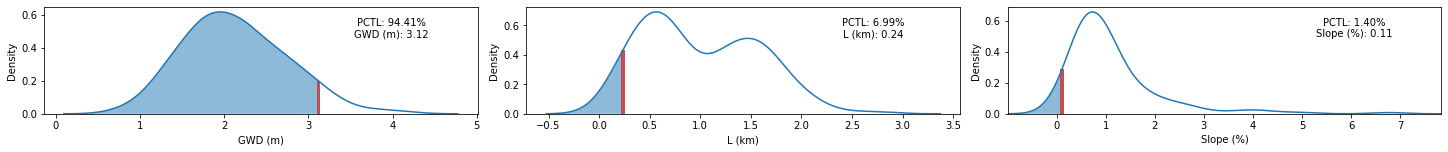

In [177]:
idx = 139
plot_summary(idx, fn_shap_values, X_false_neg)

#### Shallow GWD < 2m 

In [178]:
fn.loc[fn['L (km)'] < 0.5].loc[fn['GWD (m)'] < 2]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
6     5640  15700.0  0.776125  0.463957   0.338019       1     -1
36     188  48147.0  1.082345  0.436470   1.148642       1     -1
62    1992  32959.0  1.930622  0.465034   0.900893       1     -1
66    3730  19186.0  1.768563  0.228149   0.157506       1     -1
73    6382  14217.0  1.948803  0.127597   0.900676       1     -1
82    2393   2168.0  1.108662  0.476856   0.670128       1     -1
90     195  25867.0  1.173311  0.223865   0.544942       1     -1
123   2363   9014.0  1.353115  0.479754   0.445521       1     -1
130   2348   9016.0  1.353115  0.461062   0.327673       1     -1

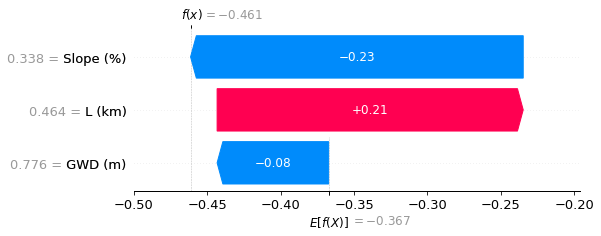

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


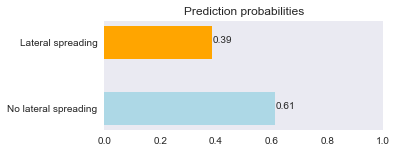

Percentile compare to the overall dataset


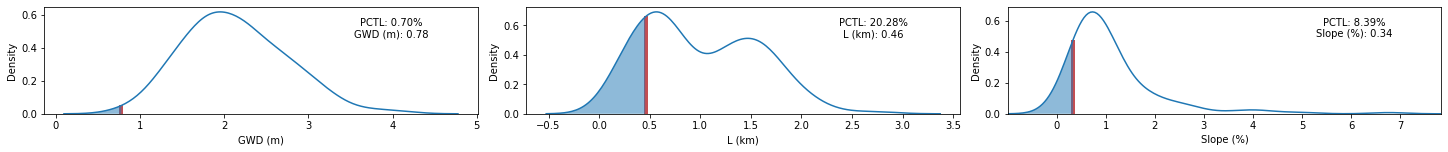

In [182]:
idx = 6
plot_summary(idx, fn_shap_values, X_false_neg)

# Global explanations

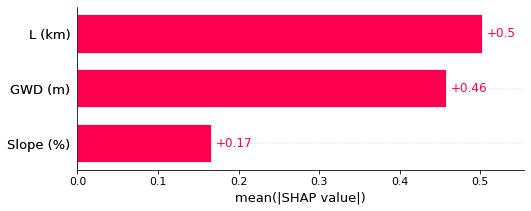

In [183]:
shap.plots.bar(shap_values)

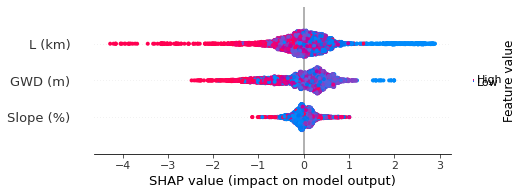

In [184]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

## True Positives

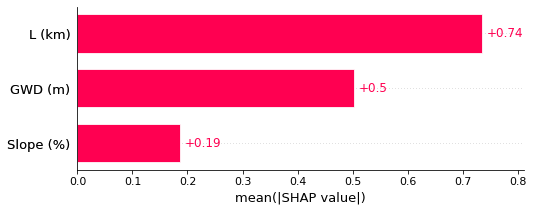

In [185]:
shap.plots.bar(tp_shap_values)

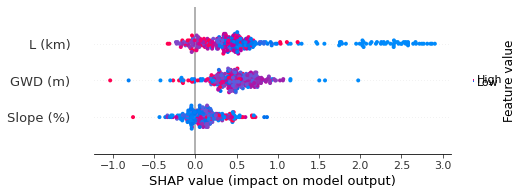

In [186]:
# summarize the effects of all the features
shap.plots.beeswarm(tp_shap_values)

### True negative

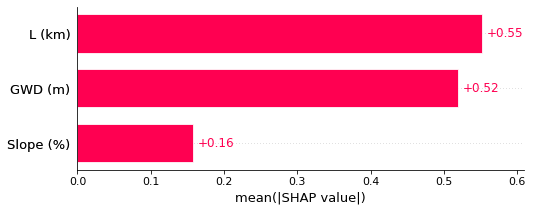

In [187]:
shap.plots.bar(tn_shap_values)

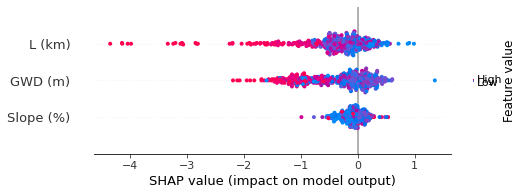

In [188]:
shap.plots.beeswarm(tn_shap_values)

### False positives

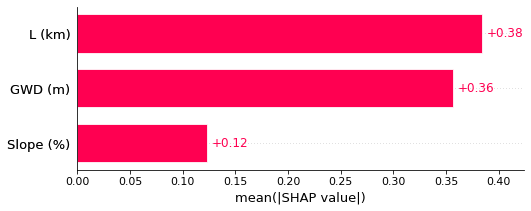

In [189]:
shap.plots.bar(fp_shap_values)

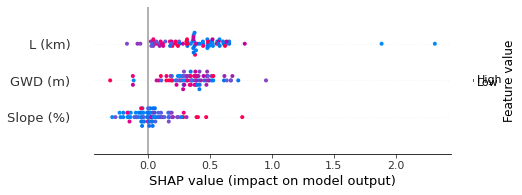

In [190]:
shap.plots.beeswarm(fp_shap_values)

### False Negative

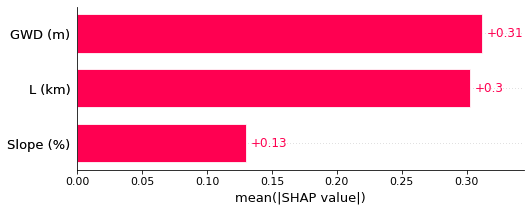

In [191]:
shap.plots.bar(fn_shap_values)

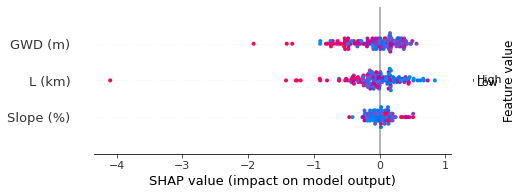

In [192]:
shap.plots.beeswarm(fn_shap_values)

# Feature relations

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


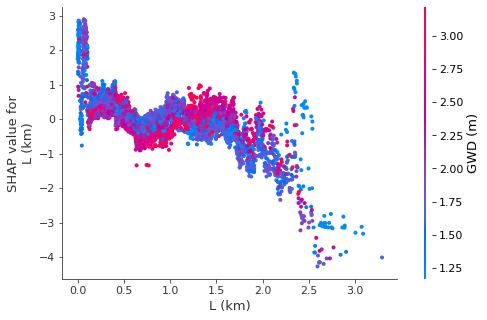

In [193]:
# explain the model's predictions using SHAP
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.dependence_plot('L (km)', shap_values, X_train, interaction_index="GWD (m)")

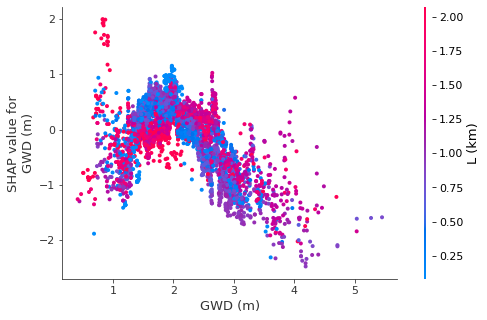

In [194]:
shap.dependence_plot('GWD (m)', shap_values, X_train)

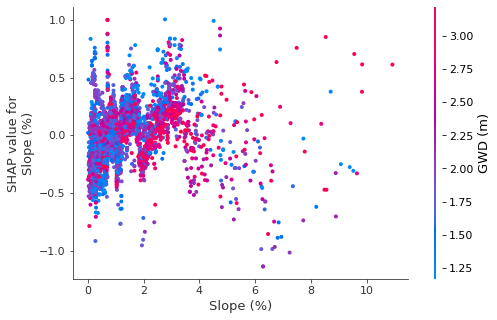

In [195]:
shap.dependence_plot('Slope (%)', shap_values, X_train)

# Specific Sites

### False Negative: 24628

In [218]:
d = X_test_target[X_test_target['Test ID'] == 24628.0]
d = d.drop(['Test ID', 'Target'], axis=1)
print("Target 1: prediction: ", model.predict(d), model.predict_proba(d))

Target 1: prediction:  [0] [[0.83523923 0.16476075]]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [219]:
fn[fn['Test ID'] == 24628.0]

index  Test ID   GWD (m)   L (km)  Slope (%)  Target  error
128   1690  24628.0  2.314934  2.31766   2.562188       1     -1

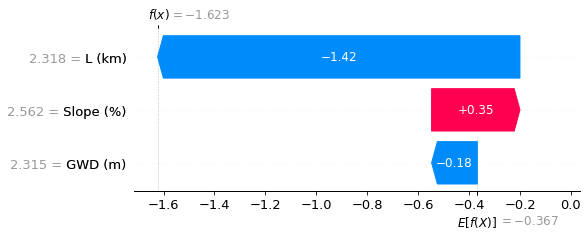

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


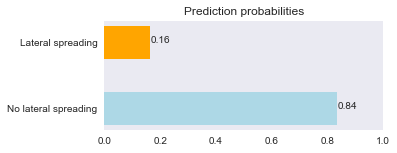

Percentile compare to the overall dataset


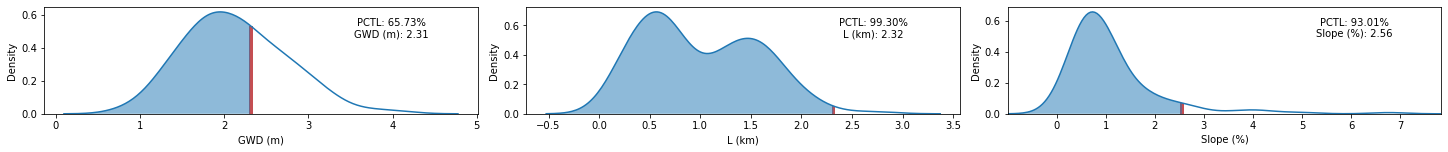

In [220]:
plot_summary(128, fn_shap_values, X_false_neg)

### False Positive - 38414.0

In [226]:
fp.head()

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0    161  38414.0  2.018221  0.681779   0.632241       0      1
1    895  11469.0  2.475069  1.567143   1.182557       0      1
2   2235  25896.0  2.186488  1.370897   0.508970       0      1
3   6300  15303.0  2.010932  0.205895   1.333204       0      1
4   3094  37532.0  2.487671  1.492929   1.000127       0      1

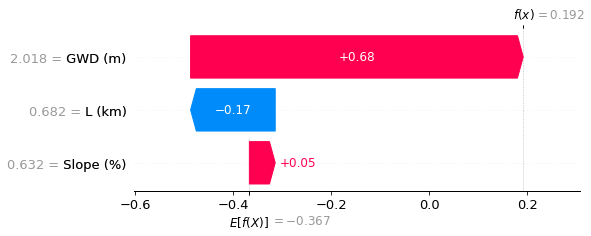

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


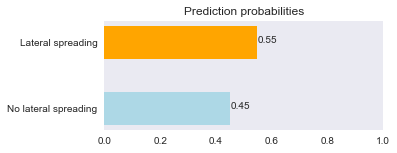

Percentile compare to the overall dataset


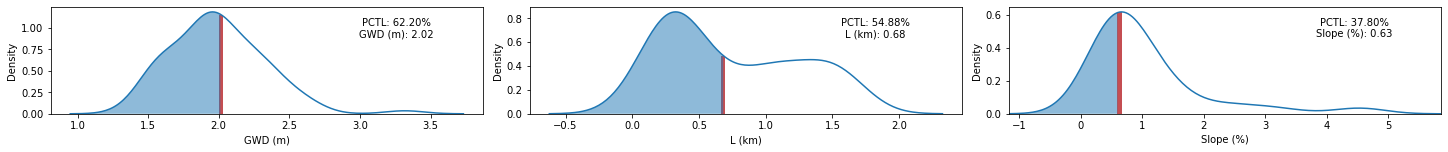

In [225]:
plot_summary(0, fp_shap_values, X_false_pos)

#### Bad learning - True negative 2556

In [229]:
d = X_test_target[X_test_target['Test ID'] == 2556.0]
d

Test ID   GWD (m)    L (km)  Slope (%)  Target
2850   2556.0  2.249877  0.984994    2.16762       0

In [230]:
d = X_test_target[X_test_target['Test ID'] == 2556.0]
d = d.drop(['Test ID', 'Target'], axis=1)
print("Target 0: prediction: ", model.predict(d), model.predict_proba(d))

Target 0: prediction:  [0] [[0.57960236 0.42039764]]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [232]:
tn[tn['Test ID'] == 2556.0]

index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
0   2850   2556.0  2.249877  0.984994    2.16762       0      0

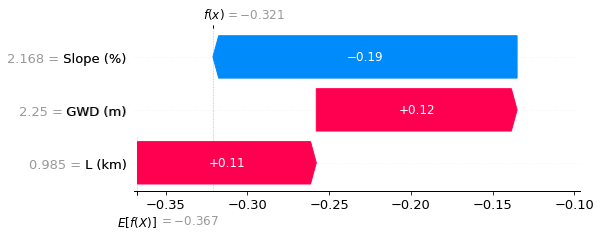

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


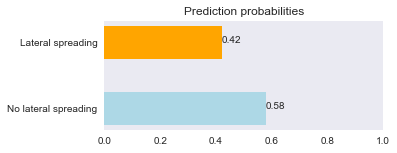

Percentile compare to the overall dataset


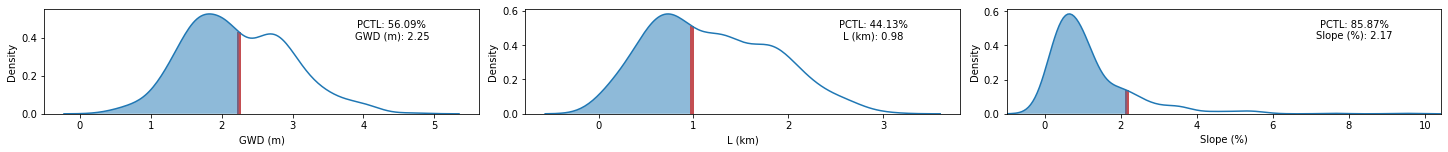

In [233]:
plot_summary(0, tn_shap_values, X_true_neg)

#### Bad learning - True pos - 38301

In [235]:
d = X_test_target[X_test_target['Test ID'] == 38301.0]
d = d.drop(['Test ID', 'Target'], axis=1)
print("Target 1: prediction: ", model.predict(d), model.predict_proba(d))

Target 1: prediction:  [1] [[0.45955533 0.5404447 ]]


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [239]:
tpx = tp.reset_index()
tpx[tpx['Test ID'] == 38301.0]


index  Test ID   GWD (m)    L (km)  Slope (%)  Target  error
13   6004  38301.0  3.475307  0.044242   3.295177       1      0

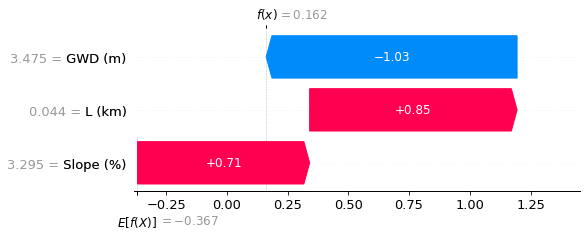

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


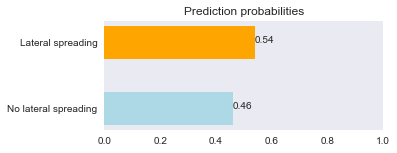

Percentile compare to the overall dataset


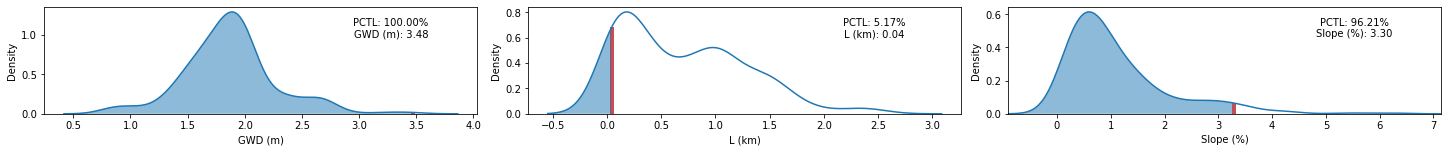

In [240]:
plot_summary(13, tp_shap_values, X_true_pos)